In [1]:
import sys
import os
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import multiprocessing as mp
from sklearn.model_selection import GroupKFold
from functools import partial

In [2]:
LABEL_ROOT = "../data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
jsons = sorted(jsons)

assert len(jsons)==800

In [3]:
def mask_data_form(idx, labelnames):


    label_shape = (2048,2048,29)
    label = np.zeros(label_shape, dtype=np.uint8)

    label_name = labelnames[idx]
    label_path = os.path.join(LABEL_ROOT, label_name)

    # read label file
    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]
        
    # iterate each class
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
            
        # polygon to mask
        class_label = np.zeros((2048,2048), dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label
    
    return np.packbits(label)

In [7]:
def mask_picklize(save_dir, is_train=True, fold=0):
    
    _labelnames = np.array(jsons)
    
    groups = [os.path.dirname(fname) for fname in _labelnames]
    ys = [0 for fname in _labelnames]
    gkf = GroupKFold(n_splits=5)
    
    label_list = []
    for i, (x, y) in enumerate(gkf.split(_labelnames, ys, groups)):
        if is_train:
            # fold번을 validation dataset으로 사용합니다.
            if i == fold:
                continue
                    
            label_list += list(_labelnames[y])
            
        else:
            label_list = list(_labelnames[y])
                
            # skip i > 0
            break

    func = partial(mask_data_form, labelnames=label_list) 
    
    num_cpu = mp.cpu_count()
    print(f"Number of CPU: {mp.cpu_count()} Name of CPU: {mp.current_process().name}")

    mask_data_lst = []

    pool = mp.Pool(num_cpu)

    inputs = [i for i in range(len(label_list))]
    outputs = pool.map(func, inputs)

    if is_train:
        file_name = 'train'
    else:
        file_name = 'val'

    with open(os.path.join(save_dir, f'{file_name}_mask_data_fold{fold}.pkl'), mode="wb") as file:
    	pickle.dump(outputs, file)

    print(f'총 {len(outputs)}개 data 저장')

In [8]:
save_dir = "/opt/ml/input/code"
mask_picklize(save_dir, is_train=False)

Number of CPU: 8 Name of CPU: MainProcess
총 160개 data 저장


# pickle 데이터Test

In [14]:
def label2rgb(label):
    image_size = label.shape[:-1] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(np.transpose(label,(2,0,1))):
        image[class_label == 1] = PALETTE[i]
        
    return image

PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [11]:
with open("/opt/ml/input/code/val_mask_data_fold0.pkl", 'rb') as f:
    pickle_data = pickle.load(f)

In [15]:
test = np.unpackbits(pickle_data[0]).reshape(2048,2048,29)

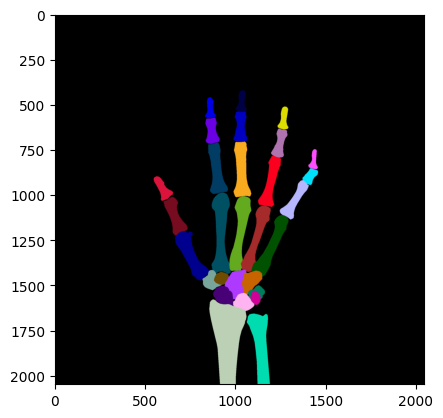

In [16]:
plt.imshow(label2rgb(test))